## Laboratorium 2

Na ostatnich zajęciach przygotowywaliście model uczenia maszynowego dla określonych danych. Zwróćcie uwagę jak przeprowadzliście preprocessing. Czy jest to poprawny sposób? Jak nazywa się takie podejście?

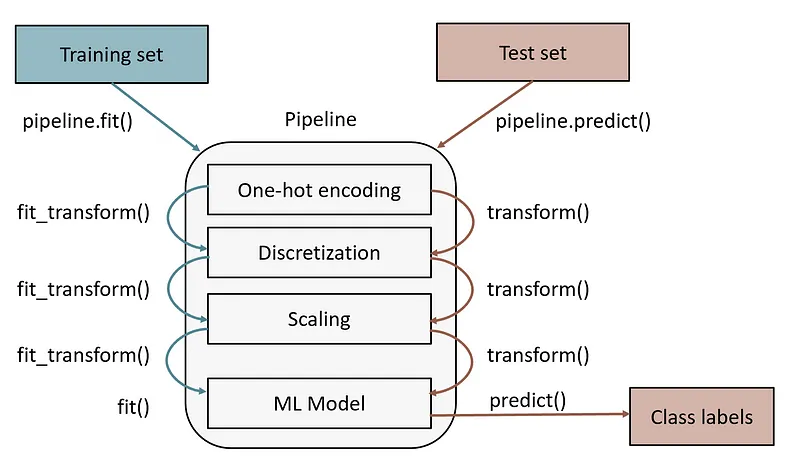

### Zadanie 1

Wykorzystując bibliotekę  `scikit-learn` i moduł `pipeline` wytrenuj modele zachowując zasady poprawnego preprocessingu. 

In [61]:
### Solution
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

set_config(transform_output = "pandas")




In [2]:
### wczytanie danych

df = pd.read_csv('../lab1/train.csv')
df_x = df.iloc[:, 1:]
df_y = df.iloc[:, 0]

df_test = pd.read_csv('../lab1/test.csv')
df_test_x = df_test.iloc[:, 1:]
df_test_y = df_test.iloc[:, 0]

In [16]:
##  Budowa Pipelinu - trzeba pamietac ze w tym przypdku mamy do czynienia z  problemem regresji

pipe_basic = Pipeline([('impute', SimpleImputer()),
                        ('model', RandomForestRegressor())])

display(pipe_basic)

Pipeline(steps=[('impute', SimpleImputer()),
                ('model', RandomForestRegressor())])

In [19]:
pipe_basic.fit(X=df_x, y=df_y)
pred_basic_test = pipe_basic.predict(df_test_x)
print('Test predictions:', pred_basic_test[:10])

Test predictions: [19.78074625 10.5784504   7.95687652 13.69242573 13.58050225 16.36241946
 15.13484314 17.4227065  18.11870276 16.15698616]


In [24]:
### modele i pipeline maja metode 'score' dla nowych danych zwraca ona R^2 dla regresji i accuracy dla klasyfikacji 
r_2_test = pipe_basic.score(X=df_test_x, y=df_test_y)
print(f'R^2 dla danych testowych: {r_2_test:.2}')


### mozna tez podac konkretna miare z modulu sklearn.metrics - przyjmuja one wektor prawdziwych wartości i wektor predykcji
mse_test = mean_squared_error(df_test_y, pred_basic_test)
print(f'MSE dla danych testowych: {mse_test:.4}')

R^2 dla danych testowych: 0.89
MSE dla danych testowych: 2.867


In [36]:
### ocena stabilnosci modelu przeprowadzona przez kroswalidcje

#### Uwaga: bierzemy scoring=neg_mean_squared_error czyli 1-MSE
#### Z dokumentacji: All scorer objects follow the convention that higher return values are better than lower return values. 

from sklearn.model_selection import cross_validate

cv_results = cross_validate(pipe_basic, df_x, df_y, scoring='neg_mean_squared_error')
scores = cv_results["test_score"]
print(
    "MSE via cross-validation:\n"
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

MSE via cross-validation:
-2.899 ± 0.135


### Zadanie 2

W jakich przypadkach konsekwencje złego podejścia do preprocessingu mogą być najpoważniejsze? Podaj przykłady sytuacji i problemów predykcyjnych.

### Pytanie *
W jakich przypadkach data leakage może prowadzić do zbyt pesymistycznej oceny jakości modelu? 


### Zadanie 3


a) Stwórz pipeline który może działać na różnym rodzaju danych do problemu klasyfikacji binarnej. Podpowiedzią mogą być poniższe punkty:

1. Define sets of columns to be transformed in different ways
2. Split data to train and test sets
3. Create pipelines for numerical and categorical features
4. Create ColumnTransformer to apply pipeline for each column set
5. Add a model to a final pipeline
6. Display the pipeline
7. Pass data through the pipeline


b) Tak stworzony pipeline można wykorzystać w funkcji `GridSearchCV` do optymalizacji hiperparametrów modelu. Przeprowdź tę operację

c) Jak zmodyfikować ten pipeline aby wybierać najlepszą metodę preprocessingu dla określonych danych?

Przetestuj pipeline na danych https://www.openml.org/search?type=data&status=active&id=45068

##### 1.a Wczytanie danych

In [6]:
import openml

# List all datasets and their properties
openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
dataset = openml.datasets.get_dataset(45068)

X, _, _, _ = dataset.get_data(dataset_format="dataframe")
y = X.loc[:, 'class']
X = X.drop(['class'], axis = 1)
print('Dane X', X.head())
print('Target: ', y.head())


Dane X    age    fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   19  134974.0             10           0.0           0.0              20   
1   41  195096.0             13           0.0           0.0              50   
2   31  152109.0              9           0.0           0.0              50   
3   40  202872.0             12           0.0           0.0              45   
4   35   98989.0              5           0.0           0.0              38   

      workclass     education      marital-status       occupation  \
0           nan  Some-college       Never-married              nan   
1  Self-emp-inc     Bachelors  Married-civ-spouse   Prof-specialty   
2       Private       HS-grad       Never-married  Exec-managerial   
3       Private    Assoc-acdm       Never-married     Adm-clerical   
4           nan           9th            Divorced              nan   

    relationship                race     sex native-country  
0      Own-child               Whit

#### 1.b Podzial na zbior treningowy i testowy

In [47]:
### Podzial na zbior treningowy i testowy
X_train,  X_test,y_train, y_test = train_test_split(X, y)

print(f'Liczba kolumn w zbiorze treningowym: {X_train.shape[1]} \nLiczba obserwacji: {X_train.shape[0]}')
print(f'Liczba kolumn w zbiorze testowym: {X_test.shape[1]} \nLiczba obserwacji: {X_test.shape[0]}')

Liczba kolumn w zbiorze treningowym: 14 
Liczba obserwacji: 36631
Liczba kolumn w zbiorze testowym: 14 
Liczba obserwacji: 12211


#### 1.c Definicja pipelinu

In [66]:


### operacje dla kolumn numerycznych
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('scale',MinMaxScaler())
])

### operacje dla kolumn kategorycznych
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))

])

#### W funkcji ColumnTransformer podajemy liste transformerow dla poszczegolnych zestawow kolumn- (name, transformer, columns) 
#### UWAGA: zamiast column selector (make_column_selector( dtype_include= np.number)) mozna podac wektor nazw kolumn, ale to rozwiazanie dla konkretnych danych


col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)


model_pipeline = Pipeline([('preprocessing', col_trans),
                           ('model', RandomForestClassifier())])

#### 1.d Trening pipelinu

In [53]:
model_pipeline.fit(X_train, y=y_train)
model_pipeline_test_pred = model_pipeline.predict_proba(X_test)

In [55]:
auc_test = roc_auc_score(y_test, model_pipeline_test_pred[:,1])
print(f'AUC dla danych testowych: {auc_test:.4}')

AUC dla danych testowych: 0.826


#### 1.e Crossvalidation

In [58]:
cv_results_task_3 = cross_validate(model_pipeline, X_train, y_train, scoring='roc_auc', cv=5)
scores = cv_results_task_3["test_score"]
print(
    "AUC via cross-validation:\n"
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

AUC via cross-validation:
0.826 ± 0.003


In [57]:
### predykcje na czesci testowej w kroswalidacji

print(scores)

[0.83183585 0.82145573 0.82852465 0.8231574  0.82613482]


#### 2.a Zdefiniowanie siatki (grid) hiperprametrow

Kazda siatka hiperparametrow jest zdefiniowna jako slownik - `dict`

Kazdy hiperparametr, który bedziemy modyfikowac w GridSearch jest definiowany w jako element słownika `dict`. 

 - Klucze tego slownika to identyfikatory hiperparametrow - kolejne identyfikatory krokow pipeline-u oddzielone znakiem  `__`.
 - Wartości w słowniku to lista wartości, które dany hiperparametr może przyjmować.

In [19]:
model_pipeline.get_params()

{'memory': None,
 'steps': [('preprocessing', ColumnTransformer(n_jobs=-1,
                     transformers=[('num_pipeline',
                                    Pipeline(steps=[('impute', SimpleImputer()),
                                                    ('scale', MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fc34c78f850>),
                                   ('cat_pipeline',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one-hot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fc34c41b5d0>)])),
  ('model', R

In [70]:
grid_params = [{'preprocessing__num_pipeline__impute__strategy':['mean', 'median', 'most_frequent'],
               'preprocessing__cat_pipeline__impute__strategy':['most_frequent', 'constant'],
               'preprocessing__cat_pipeline__one-hot__drop': ['first', None],
               'model__n_estimators': np.linspace(10, 100, 5).astype(int)}
]

gs_model_pipeline = GridSearchCV(estimator=model_pipeline,param_grid=grid_params,scoring='roc_auc', cv=3)
gs_model_pipeline.fit(X_train, y_train)

In [68]:
pd.DataFrame(gs_model_pipeline.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__num_pipeline__impute__strategy,param_preprocessing__cat_pipeline__impute__strategy,param_preprocessing__cat_pipeline__one-hot__drop,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,7.335288,0.696638,2.518563,0.106798,mean,NaN,NaN,NaN,{'preprocessing__num_pipeline__impute__strateg...,0.822369,0.825136,0.823179,0.823561,0.001161,2
1,7.145819,0.669216,2.699663,0.369121,median,NaN,NaN,NaN,{'preprocessing__num_pipeline__impute__strateg...,0.822004,0.825980,0.823187,0.823724,0.001667,1
2,5.830397,0.602467,0.692145,0.032002,most_frequent,NaN,NaN,NaN,{'preprocessing__num_pipeline__impute__strateg...,0.821298,0.825299,0.822864,0.823154,0.001646,6
3,5.435936,0.310590,0.769119,0.073528,NaN,most_frequent,NaN,NaN,{'preprocessing__cat_pipeline__impute__strateg...,0.821748,0.825730,0.822161,0.823213,0.001788,5
4,3.796512,1.063971,0.459828,0.215461,NaN,constant,NaN,NaN,{'preprocessing__cat_pipeline__impute__strateg...,0.821647,0.825745,0.822703,0.823365,0.001737,4
5,3.160918,0.486459,0.466423,0.226319,NaN,NaN,first,NaN,{'preprocessing__cat_pipeline__one-hot__drop':...,0.822364,0.826300,0.821988,0.823551,0.001950,3
6,4.319973,1.087275,0.476124,0.150488,NaN,NaN,None,NaN,{'preprocessing__cat_pipeline__one-hot__drop':...,0.821843,0.825049,0.822262,0.823051,0.001423,7
7,0.032001,0.009162,0.000000,0.000000,NaN,NaN,NaN,10.0,{'model__n_estimators': 10.0},NaN,NaN,NaN,NaN,NaN,8
8,0.049481,0.002721,0.000000,0.000000,NaN,NaN,NaN,32.5,{'model__n_estimators': 32.5},NaN,NaN,NaN,NaN,NaN,8
9,0.048653,0.009539,0.000000,0.000000,NaN,NaN,NaN,55.0,{'model__n_estimators': 55.0},NaN,NaN,NaN,NaN,NaN,8
